In [1]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import warnings
import rdkit
import mols2grid
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdmolops
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors, rdCoordGen
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
%matplotlib inline 

# ML models
import torch
from torch.nn import Linear
import torch.nn as nn
import torch.optim as optim
import torch_geometric
from torch.optim.lr_scheduler import StepLR
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv, TopKPooling, global_max_pool, global_mean_pool
from torch_geometric.nn import GINConv
from torch_geometric.nn import GlobalAttention
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
from torch_geometric.utils import to_networkx
from torch_geometric.utils import from_smiles
from torch_geometric.nn import AttentiveFP
import torch.nn.functional as F
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score, mean_absolute_error, mean_squared_error

In [2]:
# Set the seed value
random_seed = 50

# Ensure reproducibility across PyTorch (CPU & GPU)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

# Ensure reproducibility for NumPy
np.random.seed(random_seed)

# Ensure deterministic behavior in PyTorch operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
df = pd.read_csv("tg_inliers.csv")
df.shape

(6815, 3)

In [4]:
df

,smiles,tg,Outlier
0,*CC(*)C,-3.0,1
1,*CC(*)CC,-24.1,1
2,*CC(*)CCC,-37.0,1
3,*CC(*)C(C)C,60.0,1
4,*CC(*)CCCC,-50.0,1
...,...,...,...
6810,*CC(*)(F)C(=O)OCCC,62.0,1
6811,*CC(F)(F)C1(F)C(*)CC(O)(C(F)(F)F)C1(F)F,152.0,1
6812,*CC(F)(F)C1(F)CC(CC(O)(C(F)(F)F)C(F)(F)F)CC1*,98.0,1
6813,*CC(F)(F)C1(F)CC(C(O)(C(F)(F)F)C(F)(F)F)CC1*,118.0,1


In [5]:
def calculate_descriptors(mol):
    if mol is None:
        return torch.zeros(1, 5, dtype=torch.float)  # Default tensor for invalid molecules
    
    descriptors = [
        Descriptors.MolWt(mol),      # Molecular weight
        Descriptors.Chi0(mol),       # Chi0 descriptor
        Descriptors.TPSA(mol),       # Topological Polar Surface Area
        Descriptors.NumHDonors(mol),  # Number of Hydrogen Bond Donors
        Descriptors.NumRotatableBonds(mol)  # Molecular flexibility
    ]
    
    return torch.tensor(descriptors, dtype=torch.float).view(1, -1)

In [6]:
# Initialize an empty list to store the graphs
graph_list = []

# Iterate over each SMILES string in the DataFrame
for i, smile in enumerate(df['smiles']):
    # Generate the graph from the SMILES string
    g = from_smiles(smile)
    
    # Ensure that the node features are in float format
    g.x = g.x.float()
    
    # Compute descriptors and convert to tensor
    mol = Chem.MolFromSmiles(smile)
    descriptor_tensor = calculate_descriptors(mol)
    
    # Create a tensor for the target value (tg) and reshape it
    y = torch.tensor(df['tg'][i], dtype=torch.float).view(1, -1)
    
    # Assign tensors to the graph
    g.y = y
    g.descriptors = descriptor_tensor  # Store descriptor tensor
    
    # Append the processed graph to the list
    graph_list.append(g)

In [7]:
graph_list[2]

Data(x=[7, 9], edge_index=[2, 12], edge_attr=[12, 3], smiles='*CC(*)CCC', y=[1, 1], descriptors=[1, 5])

In [8]:
# Define the ratio for splitting the dataset (80% for training, 20% for validation)
train_ratio = 0.80

# Calculate the total number of samples in the dataset
dataset_size = len(graph_list)

# Calculate the number of samples for the training and validation sets
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Set a random seed for reproducibility
random_seed = 66
generator = torch.Generator().manual_seed(random_seed)

# Split the dataset into training and validation subsets
train_dataset, val_dataset = random_split(graph_list, [train_size, val_size], generator=generator)

In [9]:
# Create the DataLoaders for the train and val sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [10]:
class HybridGIN(nn.Module):
    def __init__(self, hidden_channels):
        super(HybridGIN, self).__init__()

        # GIN layers (MLP inside each GINConv)
        self.initial_conv = GINConv(Linear(9, hidden_channels))
        self.conv1 = GINConv(Linear(hidden_channels, hidden_channels))
        self.conv2 = GINConv(Linear(hidden_channels, hidden_channels))
        self.conv3 = GINConv(Linear(hidden_channels, hidden_channels))

        # Fully connected layers for hybrid model
        self.fc1 = Linear(hidden_channels * 2 + 5, 128)  # +5 for 5 molecular descriptors
        self.fc2 = Linear(128, 64)
        self.out = Linear(64, 1)

    def forward(self, x, edge_index, batch_index, descriptors):
        # Apply GIN layers
        hidden = self.initial_conv(x, edge_index).relu()
        hidden = self.conv1(hidden, edge_index).relu()
        hidden = self.conv2(hidden, edge_index).relu()
        hidden = self.conv3(hidden, edge_index).relu()
        
        # Global Pooling
        hidden = torch.cat([global_max_pool(hidden, batch_index), 
                            global_mean_pool(hidden, batch_index)], dim=1)

        # Ensure descriptors are of shape (batch_size, 4)
        if descriptors.dim() == 1:
            descriptors = descriptors.unsqueeze(1)  # Convert (batch_size,) → (batch_size, 1)
        
        # Concatenate descriptors with graph embeddings
        hybrid_features = torch.cat([hidden, descriptors], dim=1)

        # Fully connected layers
        out = F.relu(self.fc1(hybrid_features))
        out = F.relu(self.fc2(out))
        out = self.out(out)

        return out, hybrid_features  # Output and final feature representation

In [11]:
# Set up the device (GPU if available, otherwise CPU) and initialize the model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model with specified parameters and move it to the appropriate device
model = HybridGIN(hidden_channels=128).to(device)

# Set up the optimizer with learning rate and weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)

# Set up a Scheduler
scheduler = StepLR(optimizer, step_size=15, gamma=0.8)

In [12]:
def train():
    # Initialize total loss and total samples counters
    total_loss = total_samples = 0
    
    # Iterate through the training dataset
    for data in train_loader:
        # Move data to the appropriate device (GPU or CPU)
        data = data.to(device)
        
        # Zero out gradients from the previous step
        optimizer.zero_grad()
        
        # Forward pass through the model 
        out, _ = model(data.x, data.edge_index, data.batch, data.descriptors)
        
        # Calculate Mean Squared Error loss
        loss = F.mse_loss(out, data.y)
        
        # Backpropagate the loss to compute gradients
        loss.backward()
        
        # Update model parameters
        optimizer.step()
        
        # Accumulate the loss weighted by the number of graphs in the batch
        total_loss += float(loss) * data.num_graphs
        total_samples += data.num_graphs
    
    # Return the root mean squared error (RMSE)
    return np.sqrt(total_loss / total_samples)

In [13]:
@torch.no_grad()  # Disable gradient calculation for inference
def val(loader):
    mse = []  # List to store MSE for each batch
    model.eval()  # Set model to evaluation mode
    
    for data in loader:
        data = data.to(device)  # Move data to the device
        
        # Forward pass
        out, _ = model(data.x, data.edge_index, data.batch, data.descriptors)
        
        # Calculate MSE loss without reduction to keep per-sample losses
        l = F.mse_loss(out, data.y, reduction='none').cpu()
        mse.append(l)
    
    # Calculate and return RMSE
    rmse = float(torch.cat(mse, dim=0).mean().sqrt())
    return rmse

In [14]:
warnings.filterwarnings("ignore", category=UserWarning)


# Initialize lists to store training and val scores (RMSE values)
score_train = []
score_val = []

# Set the number of epochs for training
epochs = 150

# Loop over each epoch for training
for epoch in range(epochs):
    
    # Train the model and get the training RMSE
    train_rmse = train()

    # Adjust learning rate
    scheduler.step()

    # Validate the model and get the val RMSE
    val_rmse = val(val_loader)

    # Append the training RMSE and val RMSE to their respective lists
    score_train.append(train_rmse)
    score_val.append(val_rmse)

    # Print the progress of the training process (epoch number, train loss, val loss)
    print(f'Epoch: {epoch+1}/{epochs} | Train Loss: {train_rmse:.4f}, '
          f'Validation Loss: {val_rmse:.4f}')

Epoch: 1/150 | Train Loss: 94.7220, Validation Loss: 68.0385
Epoch: 2/150 | Train Loss: 64.7455, Validation Loss: 59.2759
Epoch: 3/150 | Train Loss: 62.0279, Validation Loss: 61.5737
Epoch: 4/150 | Train Loss: 61.1702, Validation Loss: 59.4803
Epoch: 5/150 | Train Loss: 60.0926, Validation Loss: 59.7312
Epoch: 6/150 | Train Loss: 59.2333, Validation Loss: 55.3030
Epoch: 7/150 | Train Loss: 58.5422, Validation Loss: 55.6894
Epoch: 8/150 | Train Loss: 57.8463, Validation Loss: 58.9106
Epoch: 9/150 | Train Loss: 57.0639, Validation Loss: 53.6754
Epoch: 10/150 | Train Loss: 56.3472, Validation Loss: 53.6534
Epoch: 11/150 | Train Loss: 56.1817, Validation Loss: 61.6658
Epoch: 12/150 | Train Loss: 56.1473, Validation Loss: 52.1367
Epoch: 13/150 | Train Loss: 54.8121, Validation Loss: 51.9744
Epoch: 14/150 | Train Loss: 54.8573, Validation Loss: 51.2503
Epoch: 15/150 | Train Loss: 53.4215, Validation Loss: 50.4061
Epoch: 16/150 | Train Loss: 52.9251, Validation Loss: 52.5363
Epoch: 17/150 | T

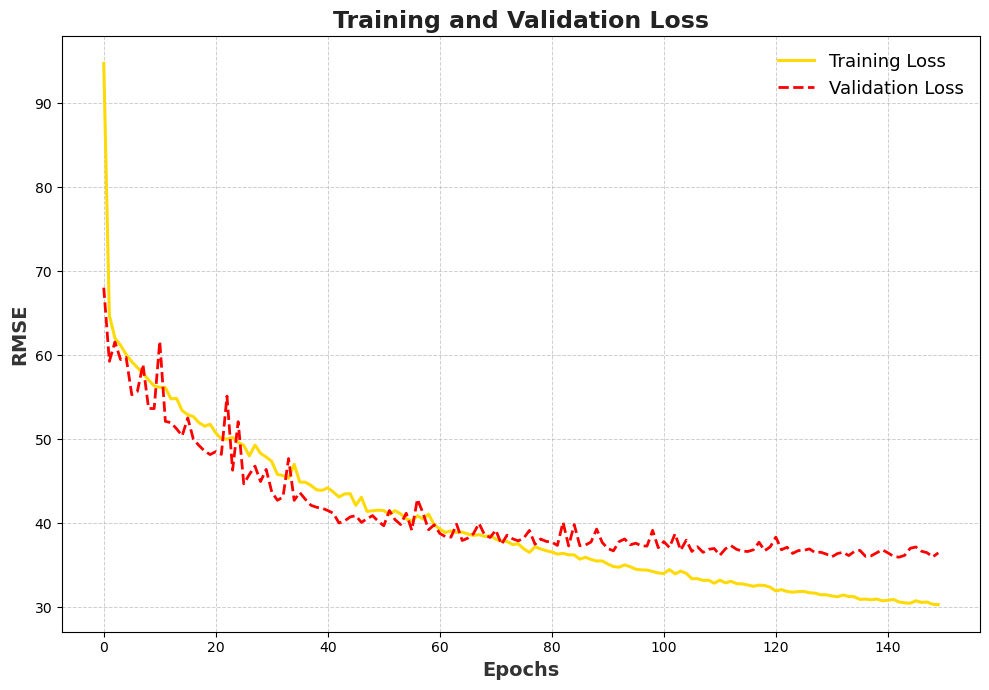

In [15]:
#Choose a style for the plot
plt.style.use("default")

# Create figure
plt.figure(figsize=(10, 7))

# Plot training and validation losses with improved styling
plt.plot(range(epochs), score_train, label='Training Loss', 
         color='#ffda06', linestyle='-', linewidth=2.2, alpha=1)

plt.plot(range(epochs), score_val, label='Validation Loss', 
         color='red', linestyle='--', linewidth=2, alpha=1)

# Labels and title with a bold but clean look
plt.xlabel('Epochs', fontsize=14, fontweight='bold', color='#333333')
plt.ylabel('RMSE', fontsize=14, fontweight='bold', color='#333333')
plt.title('Training and Validation Loss', fontsize=17, fontweight='bold', color='#222222')

# Improve grid visibility but keep it subtle
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)

# Improve legend (slightly larger, no border)
plt.legend(loc='upper right', fontsize=13, frameon=False)

# Adjust layout for a clean look
plt.tight_layout()
plt.show()

In [16]:
@torch.no_grad()  # Disable gradient computation for evaluation
def eval(loader):
    output = []  # Store model predictions and true values
    smi = []  # Store SMILES strings
    model.eval()  # Set model to evaluation mode
    
    for data in loader:
        data = data.to(device)  # Move data to the correct device (GPU/CPU)
        
        # Get model predictions
        out, _ = model(data.x, data.edge_index, data.batch, data.descriptors) 
        
        # Concatenate predictions and actual values
        concatenated_data = torch.cat((out, data.y.view(-1, 1)), dim=1)
        output.append(concatenated_data)  # Append to output list
        
        smi.append(data.smiles)  # Append SMILES strings
    
    # Stack the predictions and actual values
    stacked_output = torch.cat(output, dim=0).cpu().numpy()
    
    # Concatenate all SMILES strings
    stacked_smiles = np.concatenate(smi)
    
    # Combine predictions, actual values, and SMILES into a DataFrame
    results = pd.DataFrame(stacked_output, columns=['pred', 'actual'])
    results['smiles'] = stacked_smiles  # Add SMILES column
    
    return results

In [17]:
val_res = eval(val_loader)

In [18]:
def evaluate_preds(y_true, y_preds):
    # Calculate metrics
    metrics = {"R2": r2_score(y_true, y_preds),
               "RMSE": np.sqrt(mean_squared_error(y_true, y_preds)),
               "MAE": mean_absolute_error(y_true, y_preds)}

    # Print the metrics
    for metric, value in metrics.items():
        print(f"{metric}: {value:.3f}")

    # Return rounded metrics
    return {metric: round(value, 3) for metric, value in metrics.items()}

In [19]:
evaluate_preds(val_res['actual'], val_res['pred']);

R2: 0.892
RMSE: 36.485
MAE: 26.441


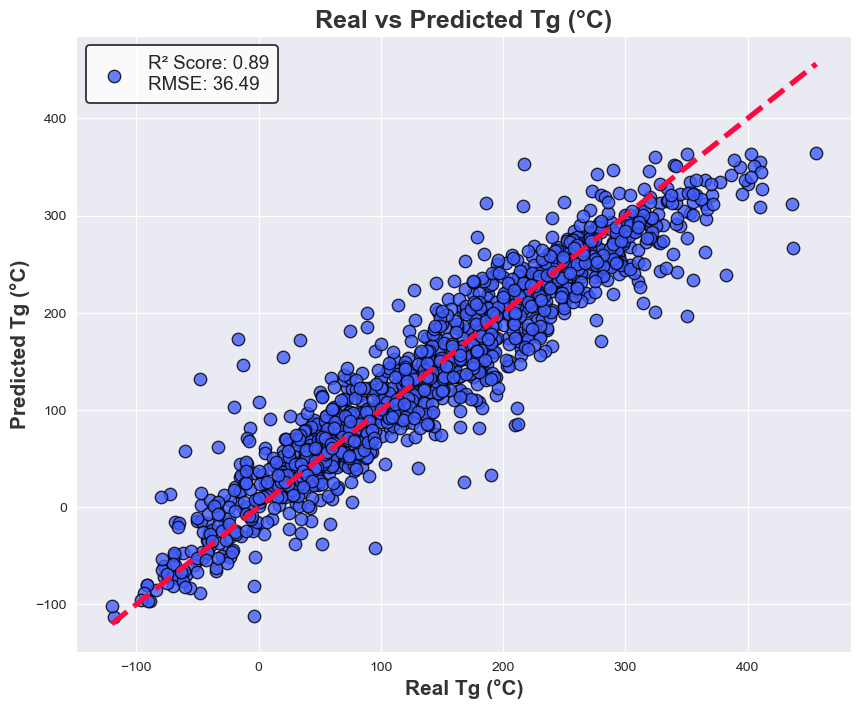

In [20]:
# Compute R² score and RMSE
r2 = r2_score(val_res['actual'], val_res['pred'])
rmse = np.sqrt(mean_squared_error(val_res['actual'], val_res['pred']))

# Choose a style for the plot
sns.set_style('darkgrid')  # Dark grid background for the plot
sns.set_palette("crest")  # Set the color palette for the plot

# Set figure size
plt.figure(figsize=(10, 8))

# Scatter plot: Actual vs Predicted values
plt.scatter(val_res['actual'], val_res['pred'], color='#415eff', alpha=0.8, edgecolors='black', s=80)

# Plot the line of perfect prediction (45-degree line)
plt.plot([min(val_res['actual']), max(val_res['actual'])], 
         [min(val_res['actual']), max(val_res['actual'])], 
         color='#ff0a3f', linestyle='--', lw=3.8, label="Perfect Fit (y=x)")  

# Create legend text
legend_text = f'R² Score: {r2:.2f}\nRMSE: {rmse:.2f}'

# Add a professional-looking legend in the **top-left corner**
legend = plt.legend([legend_text], loc="upper left", fontsize=13.5, 
                    frameon=True, edgecolor="black", facecolor="white", 
                    borderpad=0.5)

# Increase border thickness
legend.get_frame().set_linewidth(1.3)

# Title and labels
plt.title('Real vs Predicted Tg (°C)', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Real Tg (°C)', fontsize=15, fontweight='bold', color='#333333')
plt.ylabel('Predicted Tg (°C)', fontsize=15, fontweight='bold', color='#333333')

# Display grid and plot
plt.grid(True)
plt.show()

In [21]:
df_test = pd.read_csv("tg-exp.csv")
df_test

,smiles,tg exp
0,*C/C=C\C*,-102.15
1,*N[Si](*)(C)C,-82.15
2,*CC=C(C*)CCCC,-81.15
3,*CC*,-78.15
4,*CC=C(C*)CCC,-77.15
...,...,...
102,*c1ccc(Oc2ccc(-c3nc4ccccc4c(-c4ccc(Oc5ccc(-c6c...,344.85
103,*Nc1ccc(C2(c3ccc(NC(=O)c4ccc(C5(c6ccc(C(*)=O)c...,384.85
104,*Oc1ccc(-n2c(=O)c3cc4c(=O)n(-c5ccc(*)cc5)c(=O)...,398.85
105,*C(=O)Nc1ccc(C2(c3ccc(NC(=O)c4ccc(C5(c6ccc(*)c...,399.85


In [22]:
# Initialize an empty list to store the graphs
graph_list_test = []

# Iterate over each SMILES string in the DataFrame
for i, smile in enumerate(df_test['smiles']):
    # Generate the graph from the SMILES string
    g = from_smiles(smile)
    
    # Ensure that the node features are in float format
    g.x = g.x.float()
    
    # Compute descriptors and convert to tensor
    mol = Chem.MolFromSmiles(smile)
    descriptor_tensor = calculate_descriptors(mol)
    
    # Create a tensor for the target value (tg) and reshape it
    y = torch.tensor(df_test['tg exp'][i], dtype=torch.float).view(1, -1)
    
    # Assign tensors to the graph
    g.y = y
    g.descriptors = descriptor_tensor  # Store descriptor tensor
    
    # Append the processed graph to the list
    graph_list_test.append(g)

In [23]:
test_loader = DataLoader(graph_list_test, batch_size=32)

In [24]:
test_res = eval(test_loader)

In [25]:
evaluate_preds(test_res['actual'], test_res['pred']);

R2: 0.910
RMSE: 38.579
MAE: 29.472
